In [1]:
#note this now uses rubin_sim package
# See https://community.lsst.org/t/announcing-rubin-sim/5881


from rubin_sim.maf.metrics.baseMetric import BaseMetric
from scipy import interpolate

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

import rubin_sim.maf.db as db
import rubin_sim.maf.utils as utils
import rubin_sim.maf.metrics as metrics
import rubin_sim.maf.slicers as slicers
import rubin_sim.maf.metricBundles as metricBundles
import rubin_sim.maf.plots as plots
import rubin_sim.maf.maps as maps
# need a different set of utils for the stellarmags
import rubin_sim.utils as sims_utils


import glob


/data0/lsst_stack/stack/miniconda3-py38_4.9.2-0.4.2/Linux64/sims_maf/2.13.0.sims-93-g8bc2eb33+a14e41332a/python/lsst/sims/maf/db/opsimDatabase.py:95: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if groupBy is 'default' and tableName==self.defaultTable:
/data0/lsst_stack/stack/miniconda3-py38_4.9.2-0.4.2/Linux64/sims_maf/2.13.0.sims-93-g8bc2eb33+a14e41332a/python/lsst/sims/maf/db/opsimDatabase.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if groupBy is 'default' and tableName!=self.defaultTable:
/data0/lsst_stack/stack/miniconda3-py38_4.9.2-0.4.2/Linux64/sims_maf/2.13.0.sims-93-g8bc2eb33+a14e41332a/python/lsst/sims/maf/slicers/opsimFieldSlicer.py:127: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  (key is not 'bins') & (key is not 'binCol'):
/data0/lsst_stack/stack/miniconda3-py38_4.9.2-0.4.2/Linux64/sims_maf/2.13.0.sims-93-g8bc2eb33+a14e41332a/python/lsst/sims/maf/slicers/opsimFieldSlicer.py:127: SyntaxWarning: "is not" with a literal. Did yo

In [2]:
# Copy and modify the ParallaxMetric

class BDParallaxMetric(BaseMetric):
    """Calculate the distance to which one could reach a parallax SNR for a given object

    Uses columns ra_pi_amp and dec_pi_amp, calculated by the ParallaxFactorStacker.

    Parameters
    ----------
    metricName : str, opt
        Default 'parallax'.
    m5Col : str, opt
        The default column name for m5 information in the input data. Default fiveSigmaDepth.
    filterCol : str, opt
        The column name for the filter information. Default filter.
    seeingCol : str, opt
        The column name for the seeing information. Since the astrometry errors are based on the physical
        size of the PSF, this should be the FWHM of the physical psf. Default seeingFwhmGeom.
    mags : dict
        The absolute magnitude of the obeject in question. Keys of filter name, values in mags.
    distances : np.array
        Distances to try putting the object at (pc).
    atm_err : float, opt
        The expected centroiding error due to the atmosphere, in arcseconds. Default 0.01.
    badval : float, opt
        The value to return when the metric value cannot be calculated. Default 0.
    """
    def __init__(self, metricName='bdParallax', m5Col='fiveSigmaDepth',
                 filterCol='filter', seeingCol='seeingFwhmGeom',
                 badval=0, mags={'z': 18.18, 'y': 17.13}, parallax_snr=10.,
                 distances=np.arange(10, 200, 20), 
                 atm_err=0.01, normalize=False, min_exp_time=15., 
                 exptimeCol='visitExposureTime', **kwargs):
        Cols = [m5Col, filterCol, seeingCol, exptimeCol, 'ra_pi_amp', 'dec_pi_amp']
        
        units = 'pc'
        super(BDParallaxMetric, self).__init__(Cols, metricName=metricName, units=units,
                                             badval=badval, **kwargs)
        # set return type
        self.m5Col = m5Col
        self.seeingCol = seeingCol
        self.filterCol = filterCol
        self.distances = distances
        self.exptimeCol = exptimeCol
        self.mags = {}
        distance_mod = 5.0*np.log10(distances)-5.0
        for key in mags:
            self.mags[key] = mags[key] + distance_mod
        self.parallax_snr_goal = parallax_snr
        self.atm_err = atm_err
        self.filters = list(self.mags.keys())
        self.parallaxes = 1000.0/distances  #mas
        self.min_exp_time = min_exp_time
        
    def _final_sigma(self, position_errors, ra_pi_amp, dec_pi_amp):
        """Assume parallax in RA and DEC are fit independently, then combined.
        All inputs assumed to be arcsec """
        sigma_A = position_errors/ra_pi_amp
        sigma_B = position_errors/dec_pi_amp
        sigma_ra = np.sqrt(1./np.sum(1./sigma_A**2, axis=1))
        sigma_dec = np.sqrt(1./np.sum(1./sigma_B**2, axis=1))
        # Combine RA and Dec uncertainties, convert to mas
        sigma = np.sqrt(1./(1./sigma_ra**2+1./sigma_dec**2))*1e3
        return sigma

    def run(self, dataslice, slicePoint=None):
        snr = np.zeros((np.size(self.mags[self.filters[0]]), len(dataslice)), dtype='float')
        # compute SNR for all observations
        for filt in self.filters:
            if self.min_exp_time is not None:
                good = np.where((dataslice[self.filterCol] == filt) &
                                (dataslice[self.exptimeCol] >= self.min_exp_time))[0]
            else:
                good = np.where(dataslice[self.filterCol] == filt)[0]
            if np.size(good) > 0:
                snr[:, good] = mafUtils.m52snr(self.mags[str(filt)][:, np.newaxis],
                                               dataslice[self.m5Col][good])
                
        
        position_errors = np.sqrt(mafUtils.astrom_precision(dataslice[self.seeingCol],
                                                            snr)**2+self.atm_err**2)
        # uncertainty in the parallax in mas
        sigma = self._final_sigma(position_errors, dataslice['ra_pi_amp'], dataslice['dec_pi_amp'])
        fitted_parallax_snr = self.parallaxes/sigma
        result = self.badval
        # Let's interpolate to the distance where we would get our target SNR
        if np.max(fitted_parallax_snr) >= self.parallax_snr_goal:
            f = interpolate.interp1d(fitted_parallax_snr, self.distances, fill_value="extrapolate")
            result = f(self.parallax_snr_goal)
        return result

In [3]:
class VolumeSumMetric(BaseMetric):
    """Compute the total volume assuming a metric has values of distance
    """
    def __init__(self, col=None, metricName='VolumeSum', nside=None, **kwargs):
        super(VolumeSumMetric, self).__init__(col=col, metricName=metricName, **kwargs)
        self.pix_area = hp.nside2pixarea(nside)
        
    def run(self, dataSlice, slicePoint=None):
        # volume of sphere, times ratio of pixel area divided by area of sphere
        vols = 1./3. * dataSlice[self.colname]**3 * self.pix_area
        return np.sum(vols)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['observationStartMJD', 'fieldDec', 'seeingFwhmGeom', 'visitExposureTime', 'filter', 'fieldRA', 'fiveSigmaDepth'].


/data0/lsst_stack/stack/miniconda3-py38_4.9.2-0.4.2/Linux64/sims_utils/2.13.0.sims-46-g370dc29+872406ca88/python/lsst/sims/utils/stellarMags.py:80: FutureWarning: fromrecords expected a list of tuples, may have received a list of lists instead. In the future that will raise an error
  data = np.core.records.fromrecords([


Found 2044984 visits
Running:  ['_sims_maf_fbs_1_7_1_new_rolling_baseline_nexp2_v1_7_1_10yrs_L7_HEAL']


/data0/lsst_stack/stack/miniconda3-py38_4.9.2-0.4.2/Linux64/sims_maf/2.13.0.sims-93-g8bc2eb33+a14e41332a/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
<ipython-input-2-32808caa9442>:60: RuntimeWarning: divide by zero encountered in true_divide
  sigma_ra = np.sqrt(1./np.sum(1./sigma_A**2, axis=1))
<ipython-input-2-32808caa9442>:61: RuntimeWarning: divide by zero encountered in true_divide
  sigma_dec = np.sqrt(1./np.sum(1./sigma_B**2, axis=1))
<ipython-input-2-32808caa9442>:63: RuntimeWarning: divide by zero encountered in true_divide
  sigma = np.sqrt(1./(1./sigma_ra**2+1./sigma_dec**2))*1e3


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter="z" or filter="y" for columns ['observationStartLST', 'observationStartMJD', 'fieldDec', 'seeingFwhmGeom', 'altitude', 'filter', 'fieldRA', 'fiveSigmaDepth']
Found 799920 visits
Running:  ['_sims_maf_fbs_1_7_1_new_rolling_baseline_nexp2_v1_7_1_10yrs_ParallaxDcrDegenMetric_z_or_y_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.2/lib/python3.8/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = self.imshow(
/data0/lsst_stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.2/lib/python3.8/site-packages/healpy/pixelfunc.py:1581: UserWarning: monopole: 37.8181  dipole: lon: 92.3472, lat: -82.721, amp: 10.3659
  warnings.warn(


Plotting complete.
Plotting figures with "filter="z" or filter="y"" constraint now.


/data0/lsst_stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.2/lib/python3.8/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = self.imshow(
/data0/lsst_stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.2/lib/python3.8/site-packages/healpy/pixelfunc.py:1581: UserWarning: monopole: 0.236648  dipole: lon: -76.2544, lat: -69.8268, amp: 0.451949
  warnings.warn(


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['observationStartMJD', 'fieldDec', 'seeingFwhmGeom', 'visitExposureTime', 'filter', 'fieldRA', 'fiveSigmaDepth'].
Found 2034648 visits
Running:  ['_sims_maf_fbs_1_7_1_new_rolling_bulge_roll_scale0_90_nslice2_fpw0_9_nrw1_0v1_7_10yrs_L7_HEAL']


/data0/lsst_stack/stack/miniconda3-py38_4.9.2-0.4.2/Linux64/sims_maf/2.13.0.sims-93-g8bc2eb33+a14e41332a/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
<ipython-input-2-32808caa9442>:60: RuntimeWarning: divide by zero encountered in true_divide
  sigma_ra = np.sqrt(1./np.sum(1./sigma_A**2, axis=1))
<ipython-input-2-32808caa9442>:61: RuntimeWarning: divide by zero encountered in true_divide
  sigma_dec = np.sqrt(1./np.sum(1./sigma_B**2, axis=1))
<ipython-input-2-32808caa9442>:63: RuntimeWarning: divide by zero encountered in true_divide
  sigma = np.sqrt(1./(1./sigma_ra**2+1./sigma_dec**2))*1e3


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter="z" or filter="y" for columns ['observationStartLST', 'observationStartMJD', 'fieldDec', 'seeingFwhmGeom', 'altitude', 'filter', 'fieldRA', 'fiveSigmaDepth']
Found 801091 visits
Running:  ['_sims_maf_fbs_1_7_1_new_rolling_bulge_roll_scale0_90_nslice2_fpw0_9_nrw1_0v1_7_10yrs_ParallaxDcrDegenMetric_z_or_y_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.2/lib/python3.8/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = self.imshow(
/data0/lsst_stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.2/lib/python3.8/site-packages/healpy/pixelfunc.py:1581: UserWarning: monopole: 37.9762  dipole: lon: 71.0597, lat: -87.1282, amp: 10.4786
  warnings.warn(


Plotting complete.
Plotting figures with "filter="z" or filter="y"" constraint now.


/data0/lsst_stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.2/lib/python3.8/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = self.imshow(
/data0/lsst_stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.2/lib/python3.8/site-packages/healpy/pixelfunc.py:1581: UserWarning: monopole: 0.250996  dipole: lon: -74.9536, lat: -65.7247, amp: 0.45831
  warnings.warn(


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['observationStartMJD', 'fieldDec', 'seeingFwhmGeom', 'visitExposureTime', 'filter', 'fieldRA', 'fiveSigmaDepth'].
Found 2037037 visits
Running:  ['_sims_maf_fbs_1_7_1_new_rolling_bulge_roll_scale0_90_nslice3_fpw0_9_nrw1_0v1_7_10yrs_L7_HEAL']


/data0/lsst_stack/stack/miniconda3-py38_4.9.2-0.4.2/Linux64/sims_maf/2.13.0.sims-93-g8bc2eb33+a14e41332a/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
<ipython-input-2-32808caa9442>:60: RuntimeWarning: divide by zero encountered in true_divide
  sigma_ra = np.sqrt(1./np.sum(1./sigma_A**2, axis=1))
<ipython-input-2-32808caa9442>:61: RuntimeWarning: divide by zero encountered in true_divide
  sigma_dec = np.sqrt(1./np.sum(1./sigma_B**2, axis=1))
<ipython-input-2-32808caa9442>:63: RuntimeWarning: divide by zero encountered in true_divide
  sigma = np.sqrt(1./(1./sigma_ra**2+1./sigma_dec**2))*1e3


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter="z" or filter="y" for columns ['observationStartLST', 'observationStartMJD', 'fieldDec', 'seeingFwhmGeom', 'altitude', 'filter', 'fieldRA', 'fiveSigmaDepth']
Found 803260 visits
Running:  ['_sims_maf_fbs_1_7_1_new_rolling_bulge_roll_scale0_90_nslice3_fpw0_9_nrw1_0v1_7_10yrs_ParallaxDcrDegenMetric_z_or_y_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.2/lib/python3.8/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = self.imshow(
/data0/lsst_stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.2/lib/python3.8/site-packages/healpy/pixelfunc.py:1581: UserWarning: monopole: 37.8633  dipole: lon: 75.8578, lat: -86.5064, amp: 10.5806
  warnings.warn(


Plotting complete.
Plotting figures with "filter="z" or filter="y"" constraint now.


/data0/lsst_stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.2/lib/python3.8/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = self.imshow(
/data0/lsst_stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.2/lib/python3.8/site-packages/healpy/pixelfunc.py:1581: UserWarning: monopole: 0.263627  dipole: lon: -75.973, lat: -67.3227, amp: 0.432119
  warnings.warn(


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['observationStartMJD', 'fieldDec', 'seeingFwhmGeom', 'visitExposureTime', 'filter', 'fieldRA', 'fiveSigmaDepth'].
Found 2044963 visits
Running:  ['_sims_maf_fbs_1_7_1_new_rolling_footprint_6_v1_7_1_10yrs_L7_HEAL']


/data0/lsst_stack/stack/miniconda3-py38_4.9.2-0.4.2/Linux64/sims_maf/2.13.0.sims-93-g8bc2eb33+a14e41332a/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
<ipython-input-2-32808caa9442>:60: RuntimeWarning: divide by zero encountered in true_divide
  sigma_ra = np.sqrt(1./np.sum(1./sigma_A**2, axis=1))
<ipython-input-2-32808caa9442>:61: RuntimeWarning: divide by zero encountered in true_divide
  sigma_dec = np.sqrt(1./np.sum(1./sigma_B**2, axis=1))
<ipython-input-2-32808caa9442>:63: RuntimeWarning: divide by zero encountered in true_divide
  sigma = np.sqrt(1./(1./sigma_ra**2+1./sigma_dec**2))*1e3


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter="z" or filter="y" for columns ['observationStartLST', 'observationStartMJD', 'fieldDec', 'seeingFwhmGeom', 'altitude', 'filter', 'fieldRA', 'fiveSigmaDepth']
Found 807658 visits
Running:  ['_sims_maf_fbs_1_7_1_new_rolling_footprint_6_v1_7_1_10yrs_ParallaxDcrDegenMetric_z_or_y_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.2/lib/python3.8/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = self.imshow(
/data0/lsst_stack/stack/miniconda3-py38_4.9.2-0.4.2/Linux64/sims_maf/2.13.0.sims-93-g8bc2eb33+a14e41332a/python/lsst/sims/maf/plots/spatialPlotters.py:224: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(fignum, figsize=plotDict['figsize'])
/data0/lsst_stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.2/lib/python3.8/site-packages/healpy/pixelfunc.py:1581: UserWarning: monopole: 38.0511 

Plotting complete.
Plotting figures with "filter="z" or filter="y"" constraint now.


/data0/lsst_stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.2/lib/python3.8/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = self.imshow(
/data0/lsst_stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.2/lib/python3.8/site-packages/healpy/pixelfunc.py:1581: UserWarning: monopole: 0.238251  dipole: lon: -80.4013, lat: -66.2333, amp: 0.481587
  warnings.warn(


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['observationStartMJD', 'fieldDec', 'seeingFwhmGeom', 'visitExposureTime', 'filter', 'fieldRA', 'fiveSigmaDepth'].
Found 2032886 visits
Running:  ['_sims_maf_fbs_1_7_1_new_rolling_full_disk_scale0_90_nslice2_fpw0_9_nrw1_0v1_7_10yrs_L7_HEAL']


/data0/lsst_stack/stack/miniconda3-py38_4.9.2-0.4.2/Linux64/sims_maf/2.13.0.sims-93-g8bc2eb33+a14e41332a/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
<ipython-input-2-32808caa9442>:60: RuntimeWarning: divide by zero encountered in true_divide
  sigma_ra = np.sqrt(1./np.sum(1./sigma_A**2, axis=1))
<ipython-input-2-32808caa9442>:61: RuntimeWarning: divide by zero encountered in true_divide
  sigma_dec = np.sqrt(1./np.sum(1./sigma_B**2, axis=1))
<ipython-input-2-32808caa9442>:63: RuntimeWarning: divide by zero encountered in true_divide
  sigma = np.sqrt(1./(1./sigma_ra**2+1./sigma_dec**2))*1e3


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter="z" or filter="y" for columns ['observationStartLST', 'observationStartMJD', 'fieldDec', 'seeingFwhmGeom', 'altitude', 'filter', 'fieldRA', 'fiveSigmaDepth']
Found 795648 visits
Running:  ['_sims_maf_fbs_1_7_1_new_rolling_full_disk_scale0_90_nslice2_fpw0_9_nrw1_0v1_7_10yrs_ParallaxDcrDegenMetric_z_or_y_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.2/lib/python3.8/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = self.imshow(
/data0/lsst_stack/stack/miniconda3-py38_4.9.2-0.4.2/Linux64/sims_maf/2.13.0.sims-93-g8bc2eb33+a14e41332a/python/lsst/sims/maf/utils/mafUtils.py:106: UserWarning: Optimal bin calculation tried to make 204 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))
/data0/lsst_stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.2/lib/python3.8/site-packages/healpy/pixelfunc.py:1581: UserWarning: monopole: 38.6244  dipole: lon: -117.448, lat: -87.2656, amp: 10.0436
  warnings.warn(


Plotting complete.
Plotting figures with "filter="z" or filter="y"" constraint now.


/data0/lsst_stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.2/lib/python3.8/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = self.imshow(
/data0/lsst_stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.2/lib/python3.8/site-packages/healpy/pixelfunc.py:1581: UserWarning: monopole: 0.237442  dipole: lon: -75.3443, lat: -70.8688, amp: 0.475373
  warnings.warn(


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['observationStartMJD', 'fieldDec', 'seeingFwhmGeom', 'visitExposureTime', 'filter', 'fieldRA', 'fiveSigmaDepth'].
Found 2036044 visits
Running:  ['_sims_maf_fbs_1_7_1_new_rolling_full_disk_scale0_90_nslice3_fpw0_9_nrw1_0v1_7_10yrs_L7_HEAL']


/data0/lsst_stack/stack/miniconda3-py38_4.9.2-0.4.2/Linux64/sims_maf/2.13.0.sims-93-g8bc2eb33+a14e41332a/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
<ipython-input-2-32808caa9442>:60: RuntimeWarning: divide by zero encountered in true_divide
  sigma_ra = np.sqrt(1./np.sum(1./sigma_A**2, axis=1))
<ipython-input-2-32808caa9442>:61: RuntimeWarning: divide by zero encountered in true_divide
  sigma_dec = np.sqrt(1./np.sum(1./sigma_B**2, axis=1))
<ipython-input-2-32808caa9442>:63: RuntimeWarning: divide by zero encountered in true_divide
  sigma = np.sqrt(1./(1./sigma_ra**2+1./sigma_dec**2))*1e3


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter="z" or filter="y" for columns ['observationStartLST', 'observationStartMJD', 'fieldDec', 'seeingFwhmGeom', 'altitude', 'filter', 'fieldRA', 'fiveSigmaDepth']
Found 798532 visits
Running:  ['_sims_maf_fbs_1_7_1_new_rolling_full_disk_scale0_90_nslice3_fpw0_9_nrw1_0v1_7_10yrs_ParallaxDcrDegenMetric_z_or_y_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.2/lib/python3.8/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = self.imshow(
/data0/lsst_stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.2/lib/python3.8/site-packages/healpy/pixelfunc.py:1581: UserWarning: monopole: 38.5158  dipole: lon: -125.724, lat: -87.7036, amp: 10.0709
  warnings.warn(


Plotting complete.
Plotting figures with "filter="z" or filter="y"" constraint now.


/data0/lsst_stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.2/lib/python3.8/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = self.imshow(
/data0/lsst_stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.2/lib/python3.8/site-packages/healpy/pixelfunc.py:1581: UserWarning: monopole: 0.244407  dipole: lon: -76.8549, lat: -72.0544, amp: 0.456299
  warnings.warn(


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['observationStartMJD', 'fieldDec', 'seeingFwhmGeom', 'visitExposureTime', 'filter', 'fieldRA', 'fiveSigmaDepth'].
Found 2042627 visits
Running:  ['_sims_maf_fbs_1_7_1_new_rolling_full_disk_v1_7_10yrs_L7_HEAL']


/data0/lsst_stack/stack/miniconda3-py38_4.9.2-0.4.2/Linux64/sims_maf/2.13.0.sims-93-g8bc2eb33+a14e41332a/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
<ipython-input-2-32808caa9442>:60: RuntimeWarning: divide by zero encountered in true_divide
  sigma_ra = np.sqrt(1./np.sum(1./sigma_A**2, axis=1))
<ipython-input-2-32808caa9442>:61: RuntimeWarning: divide by zero encountered in true_divide
  sigma_dec = np.sqrt(1./np.sum(1./sigma_B**2, axis=1))
<ipython-input-2-32808caa9442>:63: RuntimeWarning: divide by zero encountered in true_divide
  sigma = np.sqrt(1./(1./sigma_ra**2+1./sigma_dec**2))*1e3


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter="z" or filter="y" for columns ['observationStartLST', 'observationStartMJD', 'fieldDec', 'seeingFwhmGeom', 'altitude', 'filter', 'fieldRA', 'fiveSigmaDepth']
Found 802267 visits
Running:  ['_sims_maf_fbs_1_7_1_new_rolling_full_disk_v1_7_10yrs_ParallaxDcrDegenMetric_z_or_y_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.2/lib/python3.8/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = self.imshow(
/data0/lsst_stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.2/lib/python3.8/site-packages/healpy/pixelfunc.py:1581: UserWarning: monopole: 38.7539  dipole: lon: -111.606, lat: -86.1447, amp: 10.2681
  warnings.warn(


Plotting complete.
Plotting figures with "filter="z" or filter="y"" constraint now.


/data0/lsst_stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.2/lib/python3.8/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = self.imshow(
/data0/lsst_stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.2/lib/python3.8/site-packages/healpy/pixelfunc.py:1581: UserWarning: monopole: 0.204396  dipole: lon: -86.4299, lat: -73.7922, amp: 0.512456
  warnings.warn(


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['observationStartMJD', 'fieldDec', 'seeingFwhmGeom', 'visitExposureTime', 'filter', 'fieldRA', 'fiveSigmaDepth'].
Found 2034122 visits
Running:  ['_sims_maf_fbs_1_7_1_new_rolling_rolling_nm_scale0_90_nslice2_fpw0_9_nrw1_0v1_7_10yrs_L7_HEAL']


/data0/lsst_stack/stack/miniconda3-py38_4.9.2-0.4.2/Linux64/sims_maf/2.13.0.sims-93-g8bc2eb33+a14e41332a/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
<ipython-input-2-32808caa9442>:60: RuntimeWarning: divide by zero encountered in true_divide
  sigma_ra = np.sqrt(1./np.sum(1./sigma_A**2, axis=1))
<ipython-input-2-32808caa9442>:61: RuntimeWarning: divide by zero encountered in true_divide
  sigma_dec = np.sqrt(1./np.sum(1./sigma_B**2, axis=1))
<ipython-input-2-32808caa9442>:63: RuntimeWarning: divide by zero encountered in true_divide
  sigma = np.sqrt(1./(1./sigma_ra**2+1./sigma_dec**2))*1e3


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter="z" or filter="y" for columns ['observationStartLST', 'observationStartMJD', 'fieldDec', 'seeingFwhmGeom', 'altitude', 'filter', 'fieldRA', 'fiveSigmaDepth']
Found 794094 visits
Running:  ['_sims_maf_fbs_1_7_1_new_rolling_rolling_nm_scale0_90_nslice2_fpw0_9_nrw1_0v1_7_10yrs_ParallaxDcrDegenMetric_z_or_y_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.2/lib/python3.8/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = self.imshow(
/data0/lsst_stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.2/lib/python3.8/site-packages/healpy/pixelfunc.py:1581: UserWarning: monopole: 37.6712  dipole: lon: 92.1255, lat: -81.148, amp: 9.63682
  warnings.warn(


Plotting complete.
Plotting figures with "filter="z" or filter="y"" constraint now.


/data0/lsst_stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.2/lib/python3.8/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = self.imshow(
/data0/lsst_stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.2/lib/python3.8/site-packages/healpy/pixelfunc.py:1581: UserWarning: monopole: 0.271383  dipole: lon: -68.8128, lat: -66.4662, amp: 0.422022
  warnings.warn(


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['observationStartMJD', 'fieldDec', 'seeingFwhmGeom', 'visitExposureTime', 'filter', 'fieldRA', 'fiveSigmaDepth'].
Found 2037442 visits
Running:  ['_sims_maf_fbs_1_7_1_new_rolling_rolling_nm_scale0_90_nslice3_fpw0_9_nrw1_0v1_7_10yrs_L7_HEAL']


/data0/lsst_stack/stack/miniconda3-py38_4.9.2-0.4.2/Linux64/sims_maf/2.13.0.sims-93-g8bc2eb33+a14e41332a/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
<ipython-input-2-32808caa9442>:60: RuntimeWarning: divide by zero encountered in true_divide
  sigma_ra = np.sqrt(1./np.sum(1./sigma_A**2, axis=1))
<ipython-input-2-32808caa9442>:61: RuntimeWarning: divide by zero encountered in true_divide
  sigma_dec = np.sqrt(1./np.sum(1./sigma_B**2, axis=1))
<ipython-input-2-32808caa9442>:63: RuntimeWarning: divide by zero encountered in true_divide
  sigma = np.sqrt(1./(1./sigma_ra**2+1./sigma_dec**2))*1e3


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter="z" or filter="y" for columns ['observationStartLST', 'observationStartMJD', 'fieldDec', 'seeingFwhmGeom', 'altitude', 'filter', 'fieldRA', 'fiveSigmaDepth']
Found 796518 visits
Running:  ['_sims_maf_fbs_1_7_1_new_rolling_rolling_nm_scale0_90_nslice3_fpw0_9_nrw1_0v1_7_10yrs_ParallaxDcrDegenMetric_z_or_y_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.2/lib/python3.8/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = self.imshow(
/data0/lsst_stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.2/lib/python3.8/site-packages/healpy/pixelfunc.py:1581: UserWarning: monopole: 37.48  dipole: lon: 89.6297, lat: -80.9447, amp: 9.85295
  warnings.warn(


Plotting complete.
Plotting figures with "filter="z" or filter="y"" constraint now.


/data0/lsst_stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.2/lib/python3.8/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = self.imshow(
/data0/lsst_stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.2/lib/python3.8/site-packages/healpy/pixelfunc.py:1581: UserWarning: monopole: 0.28273  dipole: lon: -69.1881, lat: -68.2281, amp: 0.39908
  warnings.warn(


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['observationStartMJD', 'fieldDec', 'seeingFwhmGeom', 'visitExposureTime', 'filter', 'fieldRA', 'fiveSigmaDepth'].
Found 2043258 visits
Running:  ['_sims_maf_fbs_1_7_1_new_rolling_six_stripe_scale0_90_nslice6_fpw0_9_nrw0_0v1_7_10yrs_L7_HEAL']


/data0/lsst_stack/stack/miniconda3-py38_4.9.2-0.4.2/Linux64/sims_maf/2.13.0.sims-93-g8bc2eb33+a14e41332a/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
<ipython-input-2-32808caa9442>:60: RuntimeWarning: divide by zero encountered in true_divide
  sigma_ra = np.sqrt(1./np.sum(1./sigma_A**2, axis=1))
<ipython-input-2-32808caa9442>:61: RuntimeWarning: divide by zero encountered in true_divide
  sigma_dec = np.sqrt(1./np.sum(1./sigma_B**2, axis=1))
<ipython-input-2-32808caa9442>:63: RuntimeWarning: divide by zero encountered in true_divide
  sigma = np.sqrt(1./(1./sigma_ra**2+1./sigma_dec**2))*1e3


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.2/lib/python3.8/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = self.imshow(
/data0/lsst_stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.2/lib/python3.8/site-packages/healpy/pixelfunc.py:1581: UserWarning: monopole: 37.4863  dipole: lon: 79.3831, lat: -86.4, amp: 11.4358
  warnings.warn(


Plotting complete.
Plotting figures with "filter="z" or filter="y"" constraint now.


/data0/lsst_stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.2/lib/python3.8/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = self.imshow(
/data0/lsst_stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.2/lib/python3.8/site-packages/healpy/pixelfunc.py:1581: UserWarning: monopole: 0.265563  dipole: lon: -75.9299, lat: -71.1431, amp: 0.42071
  warnings.warn(


Plotting complete.


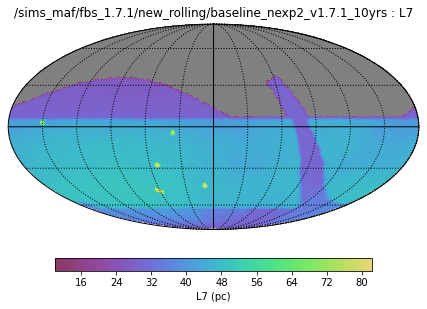

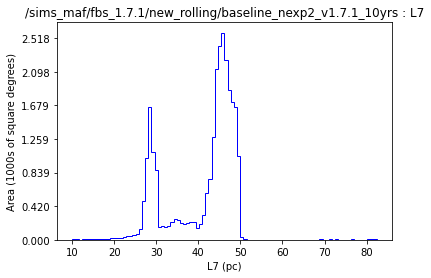

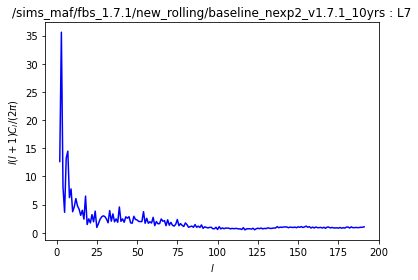

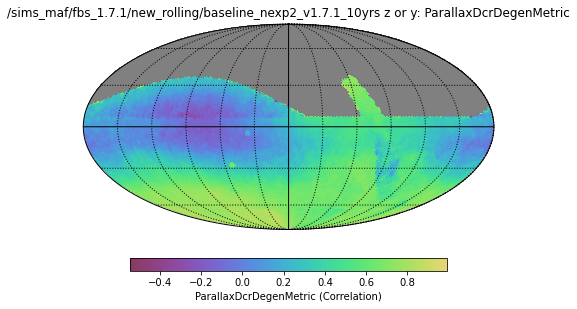

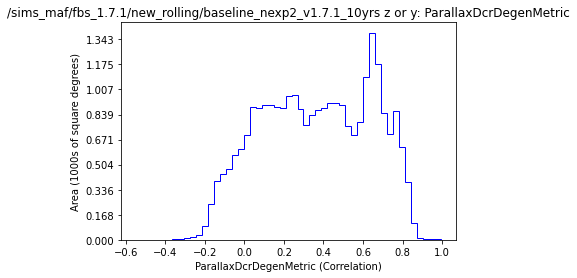

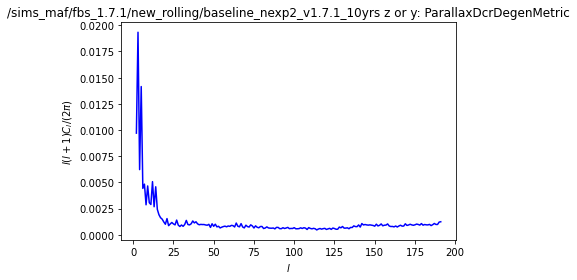

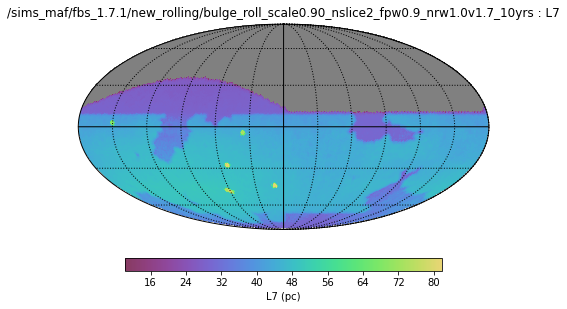

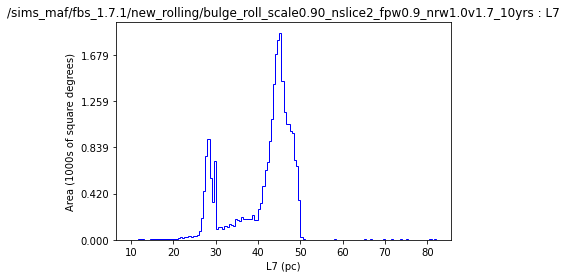

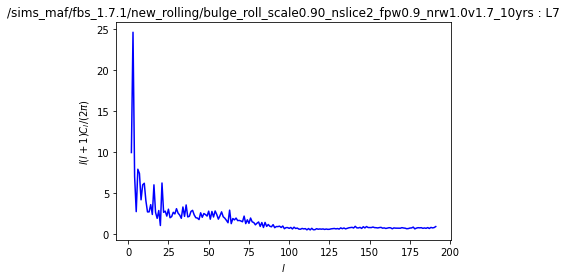

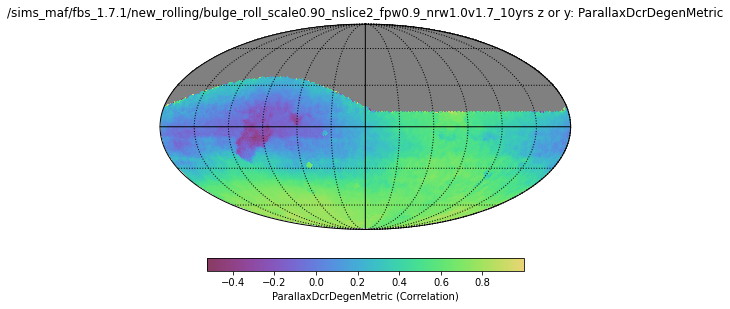

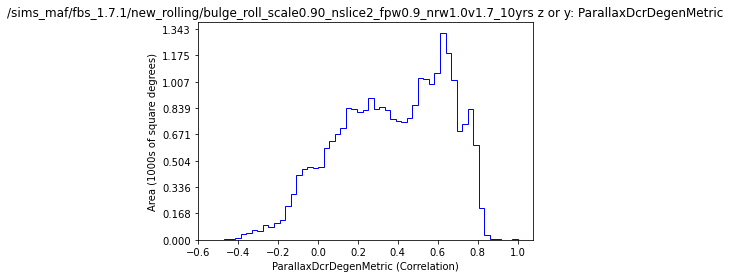

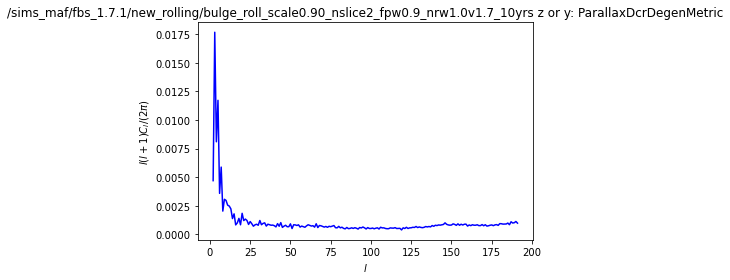

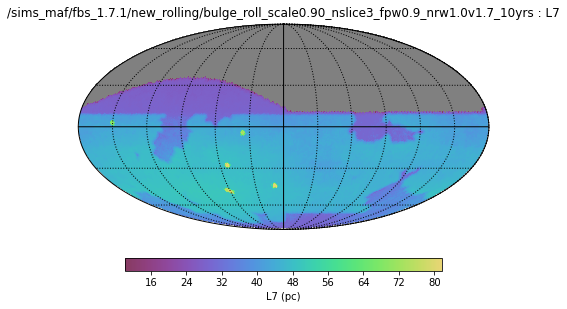

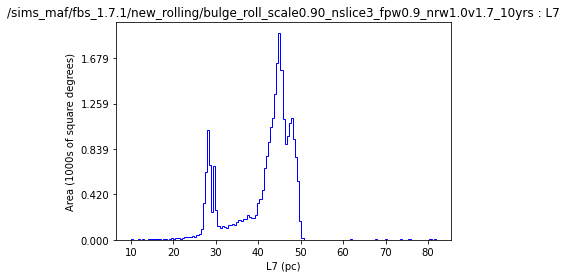

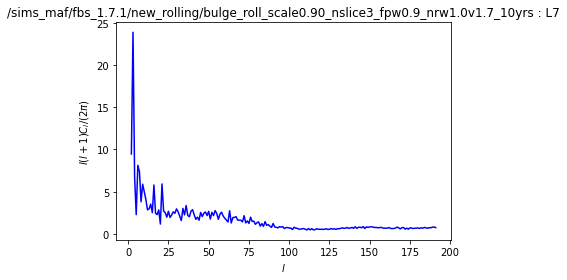

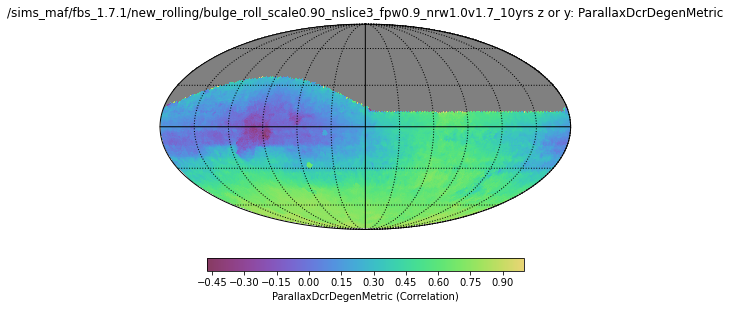

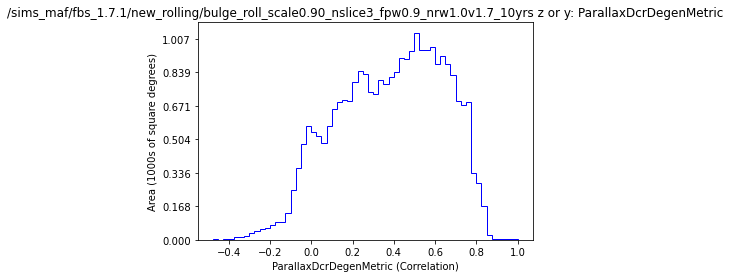

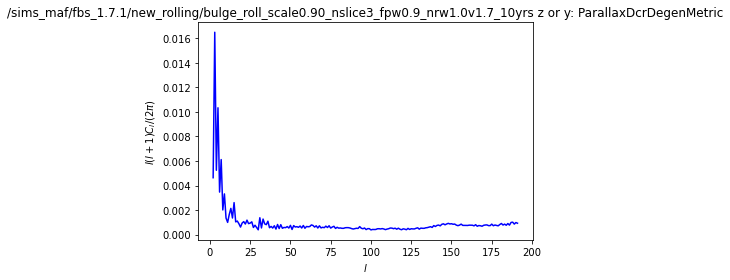

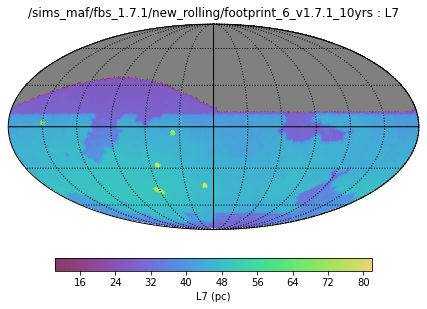

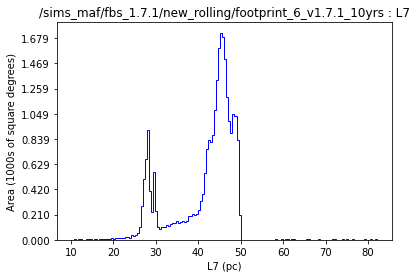

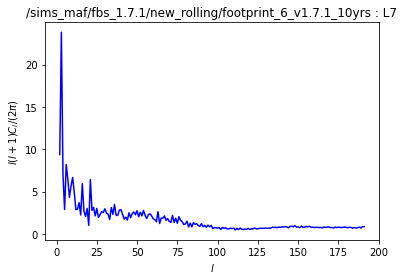

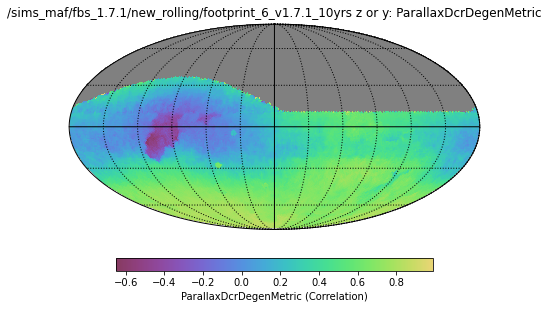

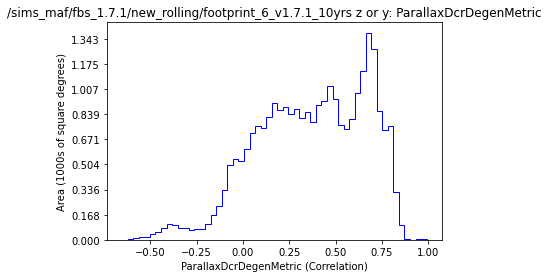

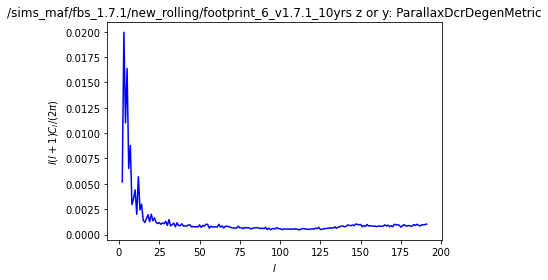

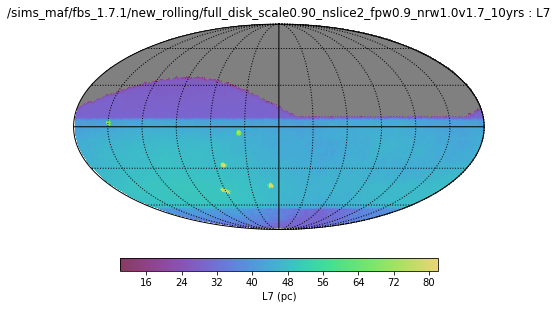

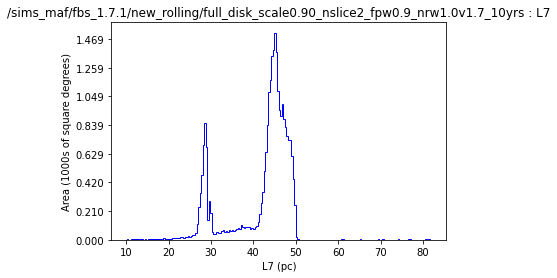

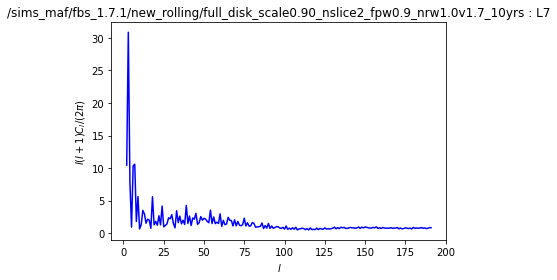

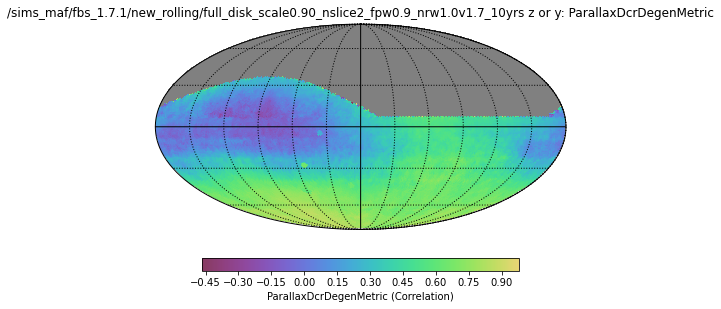

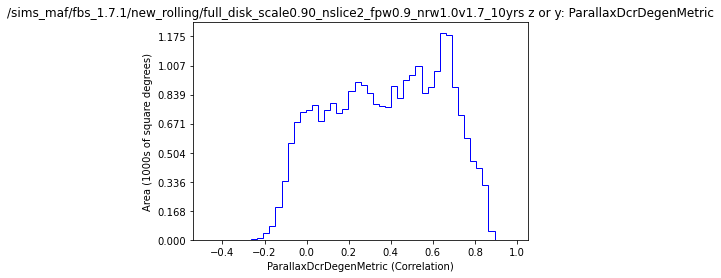

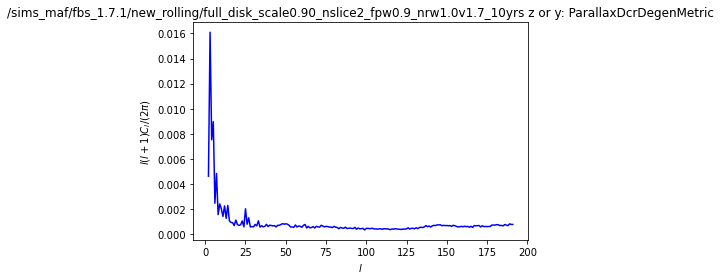

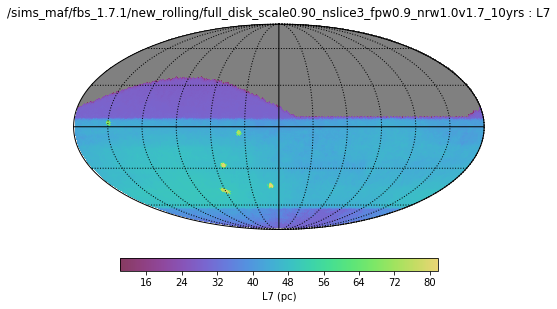

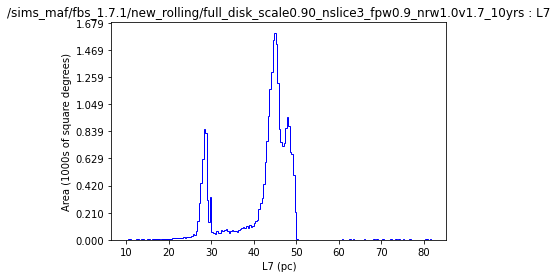

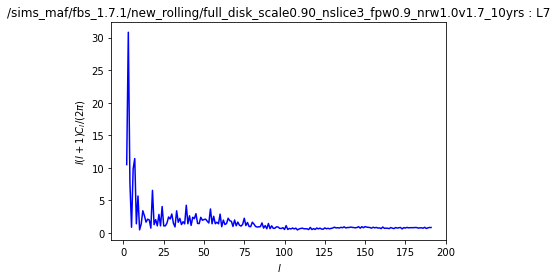

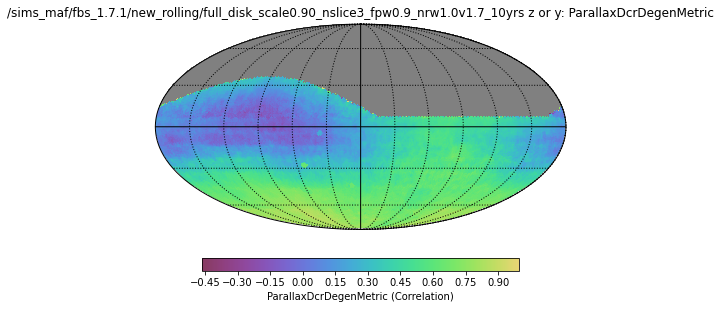

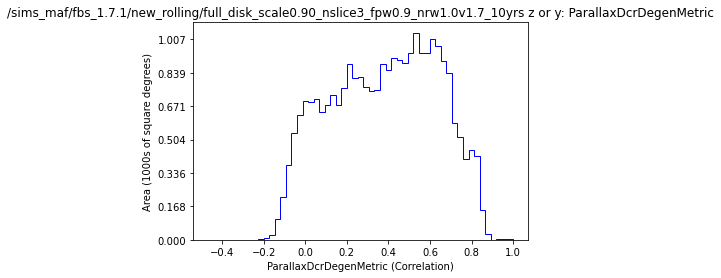

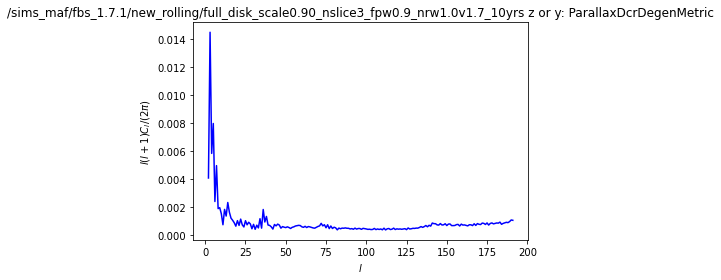

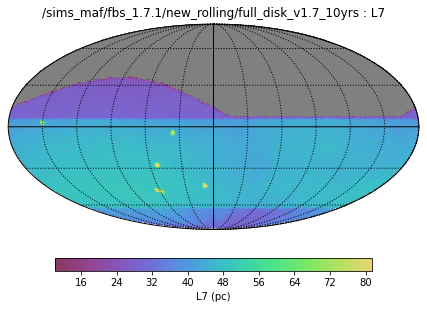

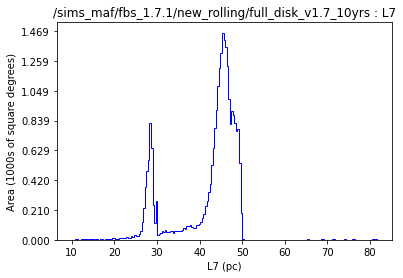

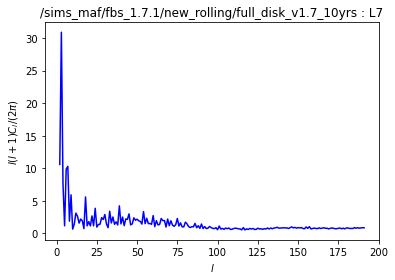

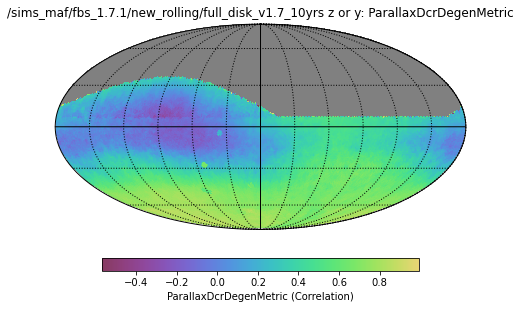

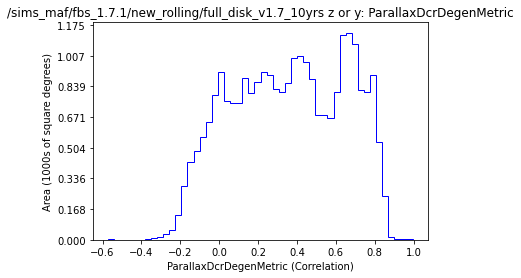

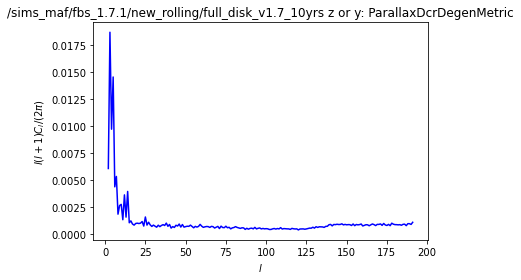

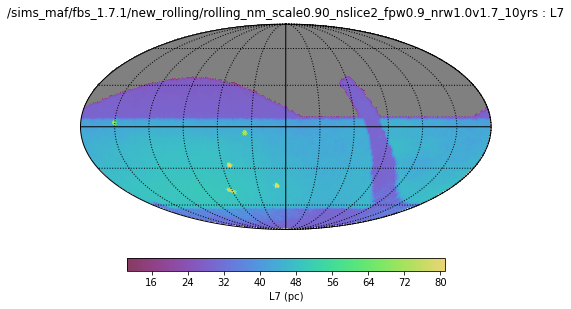

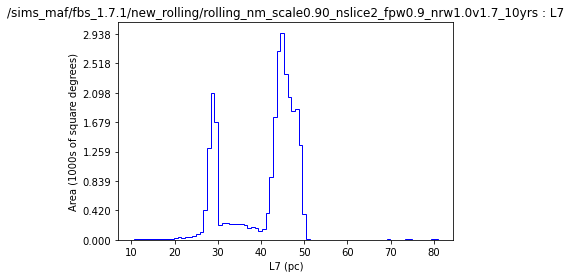

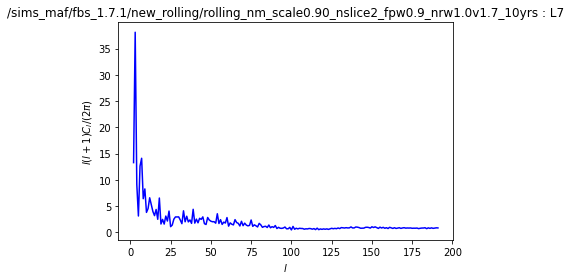

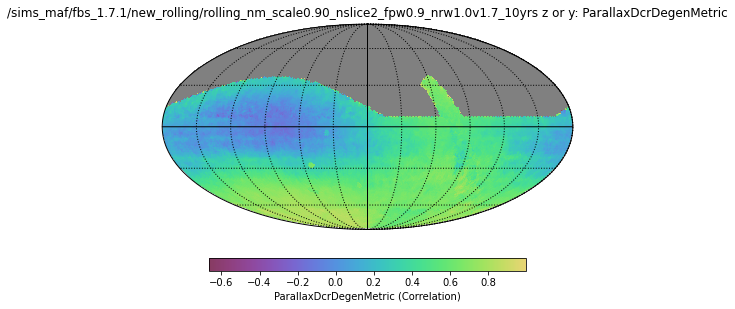

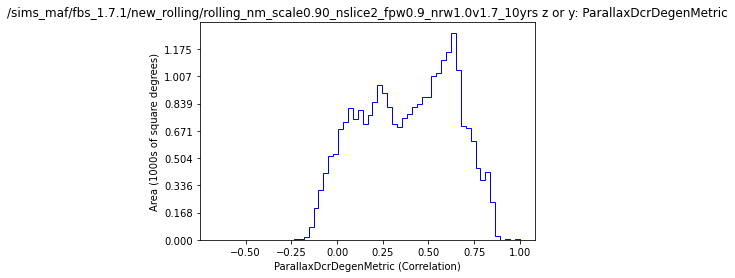

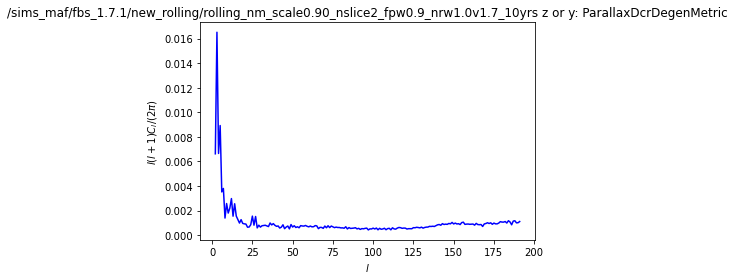

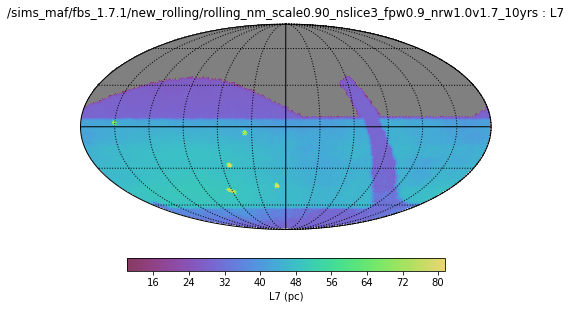

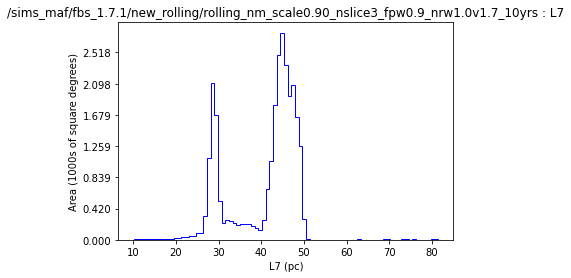

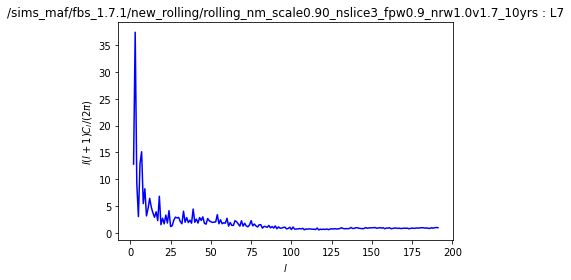

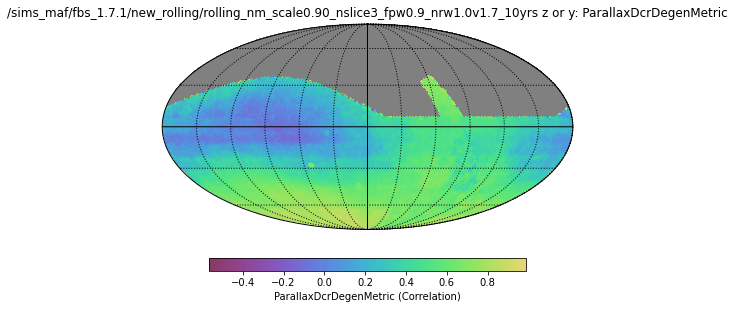

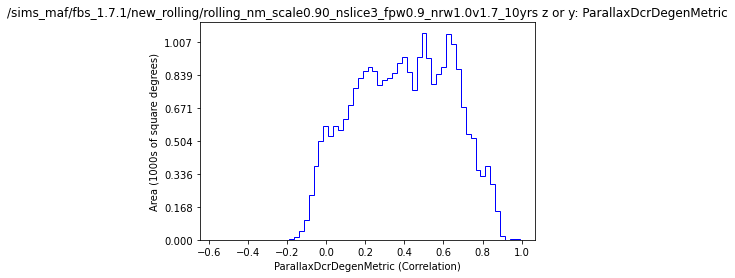

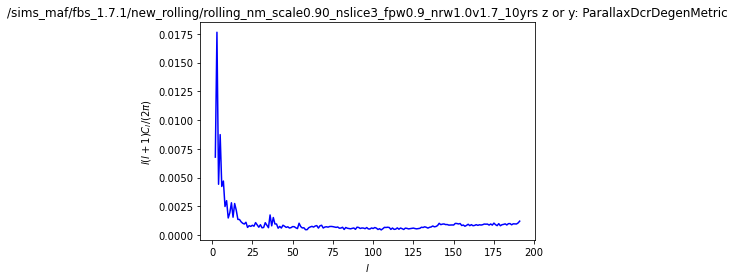

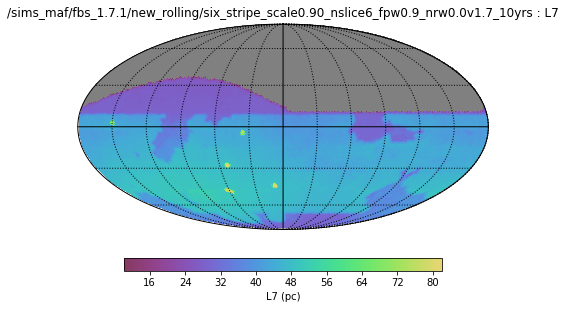

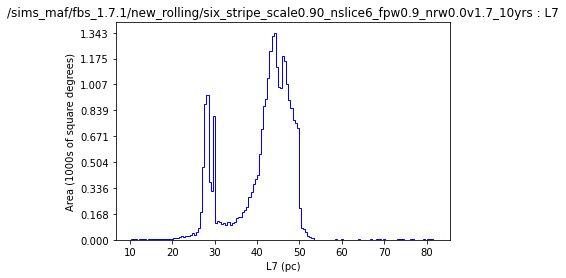

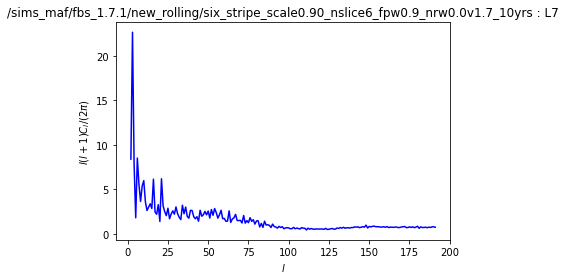

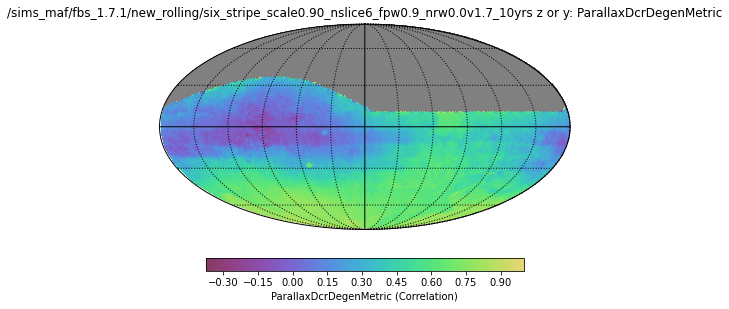

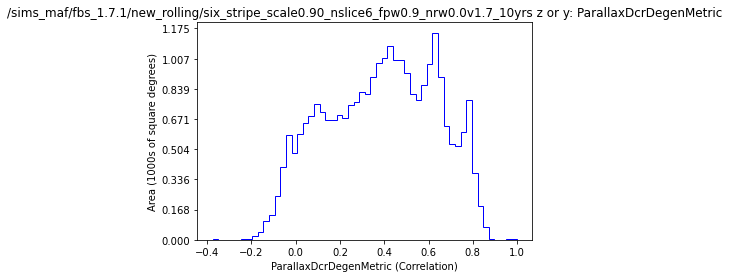

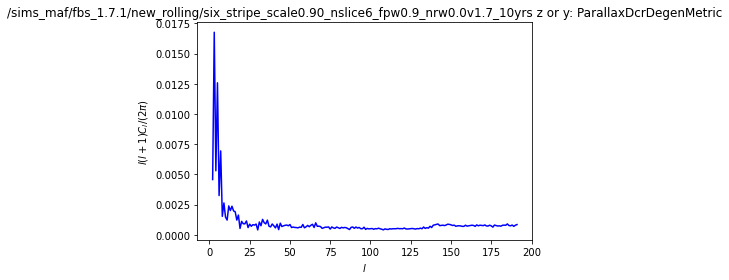

In [4]:
files = glob.glob('/sims_maf/fbs_2.0/*/*.db')
files.sort()
results = []
for dbFile in files:
    
    runName = dbFile.replace('.db', '')
    conn = db.OpsimDatabase(dbFile)
    
    outDir = runName + '_bdvol'
    outDir=outDir.replace('/sims_maf/fbs_2.0/',"BDresults/")
    resultsDb = db.ResultsDb(outDir=outDir)
    
    nside = 64
    bundleList = []
    #sql = 'filter="z" or filter="y"'
    sql = ''
    # Let's plug in the magnitudes for one type
    metric = BDParallaxMetric(mags={'i': 20.09, 'z': 18.18, 'y': 17.13}, metricName='L7')
    slicer = slicers.HealpixSlicer(nside=nside)
    summaryStats = [VolumeSumMetric(nside=nside)]
    plotDict = {}
    bundleList.append(metricBundles.MetricBundle(metric,slicer,sql, plotDict=plotDict,
                                                 summaryMetrics=summaryStats,
                                                 runName=runName))
    # add DCR degeneracy check...
    sql = 'filter="z" or filter="y"'
    metric = metrics.ParallaxDcrDegenMetric(SedTemplate='M', rmag=20.)
    bundleList.append(metricBundles.MetricBundle(metric,slicer,sql,
                                             runName=runName))
    
    bd = metricBundles.makeBundlesDictFromList(bundleList)
    bg = metricBundles.MetricBundleGroup(bd, conn, outDir=outDir, resultsDb=resultsDb)
    bg.runAll()
    bg.plotAll(closefigs=False)

    results.append(bg)

In [5]:
# Let's see how the total volume changes as we change the footprint
for name, result in zip(files, results):
    key = list(result.bundleDict.keys())[0]
    result.bundleDict[key]
    print(name, result.bundleDict[key].summaryValues)

/sims_maf/fbs_1.7.1/new_rolling/baseline_nexp2_v1.7.1_10yrs.db {'VolumeSum': 215030.0914341582}
/sims_maf/fbs_1.7.1/new_rolling/bulge_roll_scale0.90_nslice2_fpw0.9_nrw1.0v1.7_10yrs.db {'VolumeSum': 214666.22908174188}
/sims_maf/fbs_1.7.1/new_rolling/bulge_roll_scale0.90_nslice3_fpw0.9_nrw1.0v1.7_10yrs.db {'VolumeSum': 213333.35426955868}
/sims_maf/fbs_1.7.1/new_rolling/footprint_6_v1.7.1_10yrs.db {'VolumeSum': 217860.29062629884}
/sims_maf/fbs_1.7.1/new_rolling/full_disk_scale0.90_nslice2_fpw0.9_nrw1.0v1.7_10yrs.db {'VolumeSum': 218400.49511754274}
/sims_maf/fbs_1.7.1/new_rolling/full_disk_scale0.90_nslice3_fpw0.9_nrw1.0v1.7_10yrs.db {'VolumeSum': 217040.63634401702}
/sims_maf/fbs_1.7.1/new_rolling/full_disk_v1.7_10yrs.db {'VolumeSum': 221271.99680747621}
/sims_maf/fbs_1.7.1/new_rolling/rolling_nm_scale0.90_nslice2_fpw0.9_nrw1.0v1.7_10yrs.db {'VolumeSum': 209269.40703522819}
/sims_maf/fbs_1.7.1/new_rolling/rolling_nm_scale0.90_nslice3_fpw0.9_nrw1.0v1.7_10yrs.db {'VolumeSum': 207600.902